In [7]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from numba import njit,prange,objmode,jit
import os.path
from tqdm import tqdm,trange
import scienceplots

# setup of 2D q-state Potts model
@jit(forceobj=True)
def potts_energy(spins, J, h):
    """计算Potts模型的能量

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目
        J: 相邻自旋互相作用能量强度

    Returns:
        系统总能量,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算相邻自旋互作用能
    E_J = J * np.sum(spins == np.roll(spins, 1, axis=0))
    E_J += J * np.sum(spins == np.roll(spins, -1, axis=0))
    E_J += J * np.sum(spins == np.roll(spins, 1, axis=1))
    E_J += J * np.sum(spins == np.roll(spins, -1, axis=1))
    E_J /= 2
    E_J += h * np.sum(spins)

    # 求和得到能量
    E = -E_J
    return E

# magnetization
@njit
def potts_magnetization(spins):
    """计算Potts模型的磁化强度

    Args:
        spins: 自旋状态,shape=(N, N)的数组,其中N是格子数目

    Returns:
        系统磁化强度,标量
    """

    # 获取形状
    N = spins.shape[0]

    # 计算磁化强度
    M = np.sum(spins) / N**2
    return M

In [8]:
T_series = np.linspace(0.5,2.5,100)
k=1
q=3
J=1
h=0
fig_dir = '../report/files/assets/'
# matplotlib use tight layout
plt.style.use(['science','nature'])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


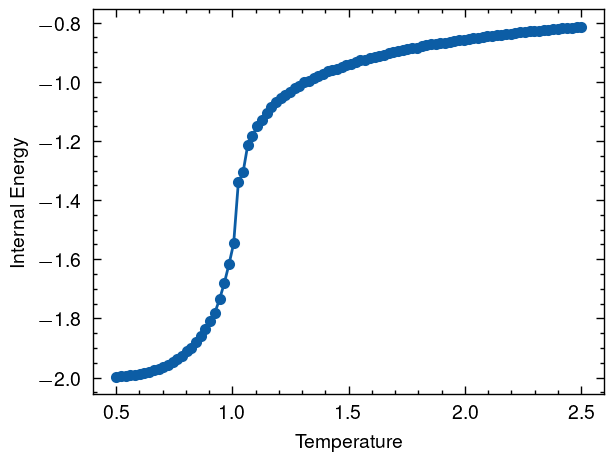

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# internal energy
@jit(forceobj=True)
def internal_energy(spin_series, J, h):
    """计算内能
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        内能,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 求和得到内能
    E = np.mean(E_series) / spin_series.shape[1]**2
    return E
# internal energy
U_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        U_series[i] = internal_energy(data, J, h)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, U_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Internal Energy')
plt.savefig(fig_dir+'internal_energy.png',dpi=300)
plt.show()

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


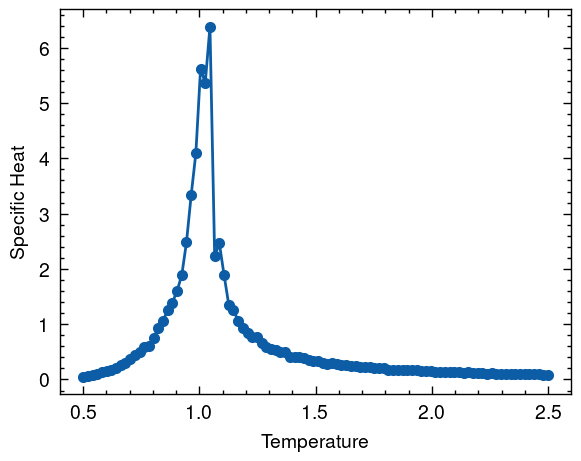

In [10]:
# specific heat
@jit(forceobj=True)
def specific_heat(spin_series, J, h, T, N):
    """计算比热
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        J: 相邻自旋互相作用能量强度
        h: 外磁场强度
    Returns:
        比热,标量
    """
    
    # 计算能量
    E_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        E_series[i] = potts_energy(spin_series[i,:,:], J, h)
    # 计算能量平方
    E2_series = E_series**2
    # 求和得到比热
    C = np.mean(E2_series) - np.mean(E_series)**2
    C = C / np.square(k*T*N)
    return C

# specific heat
C_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        N = data.shape[1]
        C_series[i] = specific_heat(data, J, h, T, N)
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, C_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.savefig(fig_dir+'specific_heat.png',dpi=300)
plt.show()

In [11]:
# find critical temperature (peak of specific heat)
T_c = T_series[np.argmax(C_series)]
print('Critical Temperature: {:.2f}'.format(T_c))

Critical Temperature: 1.05


  0%|          | 0/100 [00:00<?, ?it/s]

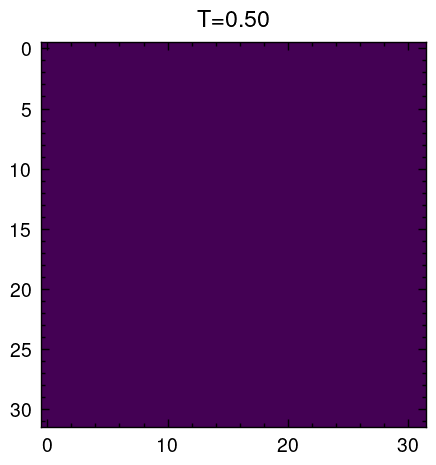

 21%|██        | 21/100 [00:01<00:03, 23.12it/s]

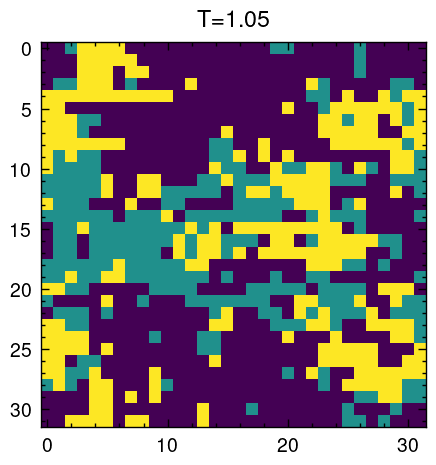

 95%|█████████▌| 95/100 [00:02<00:00, 73.70it/s]

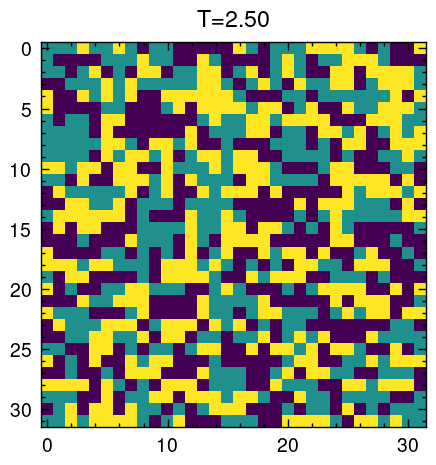

100%|██████████| 100/100 [00:03<00:00, 30.95it/s]


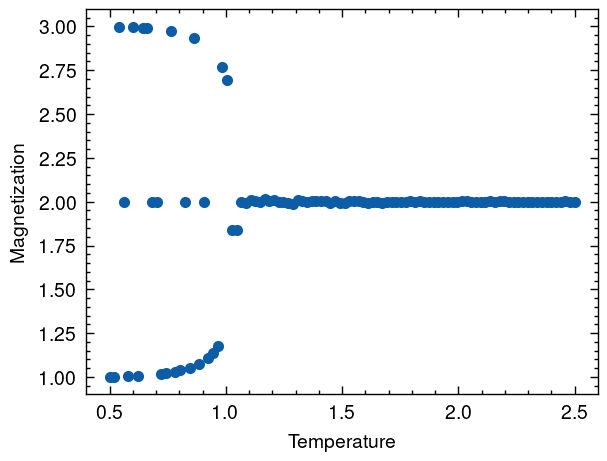

In [12]:
# magnetization
@jit
def magnetization(spin_series):
    """计算磁化强度
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
    Returns:
        M: 磁化强度,标量
    """
    
    # 计算磁化强度
    M_series = np.zeros(shape=(spin_series.shape[0]))
    for i in range(spin_series.shape[0]):
        M_series[i] = potts_magnetization(spin_series[i,:,:])
    # 求和得到磁化强度
    M = np.mean(M_series)
    return M

M_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        M_series[i] = magnetization(data)
        if i == 0 or T==T_c or i==len(T_series)-1:
            plt.imshow(data[-1,:,:])
            plt.title('T={:.2f}'.format(T))
            plt.savefig(fig_dir+'m_{}.png'.format(T),dpi=300)
            plt.show()
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
# plot
plt.plot(T_series, M_series, 'o')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.show()

100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


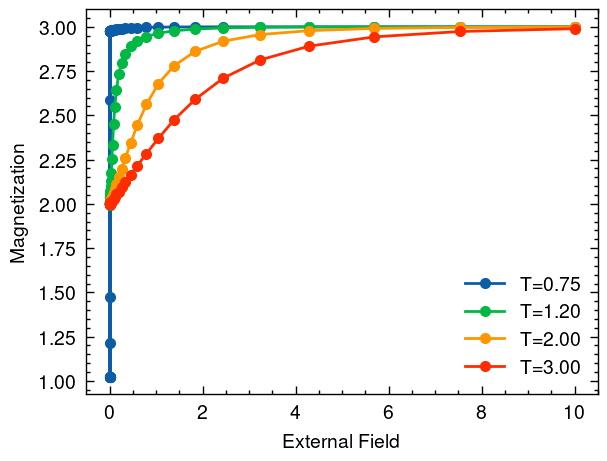

In [13]:
# Plot magnetization w.r.t h when T=0.75,1.2,2,3
T_set = [0.75,1.2,2,3]
h_series = np.logspace(-5, 1, 50)
h_series = np.insert(h_series, 0, 0)
for i in trange(len(T_set)):
    T = T_set[i]
    M_series = np.zeros(shape=(len(h_series)))
    for j in range(len(h_series)):
        h = h_series[j]
        # load data
        if os.path.isfile('Potts_Data_h/spin_history_{}_{:}_{:.2f}.npy'.format(q, h, T)):
            data = np.load('Potts_Data_h/spin_history_{}_{:}_{:.2f}.npy'.format(q, h, T))
            data = data[data.shape[0]//2:,:,:]
            M_series[j] = magnetization(data)
        else:
            raise ValueError(f'Simulation trajectory for T={T} ,q={q} and h={h} does not exist!')
    # plot
    plt.plot(h_series, M_series, 'o-', label='T={:.2f}'.format(T))
plt.xlabel('External Field')
plt.ylabel('Magnetization')
plt.legend()
plt.savefig(fig_dir+'magnetization.png',dpi=300)
plt.show()

 95%|█████████▌| 95/100 [00:22<00:01,  4.40it/s]/home/youmans/anaconda3/envs/jax/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:523: RuntimeWarning: overflow encountered in exp
  return func(xdata, *params) - ydata
100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


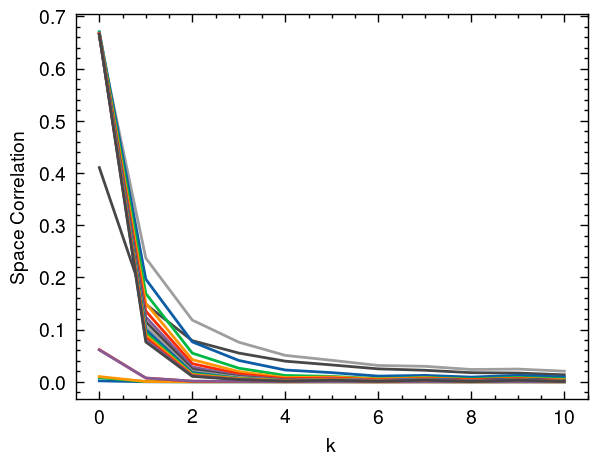

In [52]:
# space correlation and characteristic length
@jit(forceobj=True)
def space_correlation(spin_series, k):
    """计算空间相关函数
    Args:
        spin_series: 自旋状态序列,shape=(n_steps, N, N)的数组,其中n_steps是模拟步数,N是格子数目
        k: |i-j|
    Returns:
        Gamma: 空间相关函数 \Gamma(k) = 1/(4N^2) sum_i sum_{j=i+-(0,k) or (k,0)} <s_i s_j>-<s_i><s_j>
    """
    si_sj = 0
    N = spin_series.shape[1]
    si_sj += np.sum(spin_series * np.roll(spin_series,k,1))
    si_sj += np.sum(spin_series * np.roll(spin_series,k,2))
    si_sj += np.sum(spin_series * np.roll(spin_series,-k,1))
    si_sj += np.sum(spin_series * np.roll(spin_series,-k,2))
    si_sj_mean = si_sj/spin_series.shape[0]
    s_mean = np.mean(spin_series, axis = 0)
    si_mean_sj_mean= np.sum(s_mean*np.roll(s_mean,k,0)) + np.sum(s_mean*np.roll(s_mean,k,1)+s_mean*np.roll(s_mean,-k,0)) + np.sum(s_mean*np.roll(s_mean,-k,1))
    Gamma_k = 1/(4*N**2) * (si_sj_mean - si_mean_sj_mean)
    return Gamma_k

from scipy.optimize import curve_fit
@jit(forceobj=True)
def func(x, a, b):
    return a * np.exp(-x/b)

@jit(forceobj=True)
def characteristic_length(Gamma):
    """计算特征长度
    Args:
        Gamma: 空间相关函数
    Returns:
        xi: 特征长度,标量 Gamma(k) = exp(-k/xi) => ln(Gamma(k)) = -k/xi
    """
        
    # 计算特征长度
    k = np.arange(1,len(Gamma)+1)
    gamma_0, xi = curve_fit(func, k, Gamma)[0]
    return xi

xi_series = np.zeros(shape=(len(T_series)))
for i in trange(len(T_series)):
    T = T_series[i]
    # load data
    if os.path.isfile('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T)):
        data = np.load('Potts_Data/spin_history_{}_{:.2f}.npy'.format(q, T))
        data = data[data.shape[0]//2:,:,:]
        Gamma = [space_correlation(data, k) for k in range(0,11)]
        xi_series[i] = characteristic_length(Gamma)
        if i%5==0:
            plt.plot(np.arange(0,11), Gamma, label=f'T={T:.2f}')
    else:
        raise ValueError(f'Simulation trajectory for T={T} and q={q} does not exist!')
plt.xlabel('k')
plt.ylabel('Space Correlation')
plt.show()

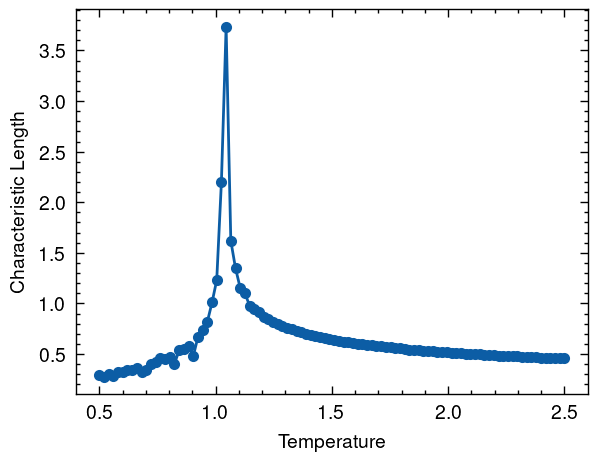

In [53]:
plt.plot(T_series, xi_series, 'o-')
plt.xlabel('Temperature')
plt.ylabel('Characteristic Length')
plt.savefig(fig_dir+'xi.png',dpi=300)
plt.show()

In [54]:
T_c_xi = T_series[np.argmax(xi_series)]
print('Critical Temperature: {:.2f}'.format(T_c))

Critical Temperature: 1.05


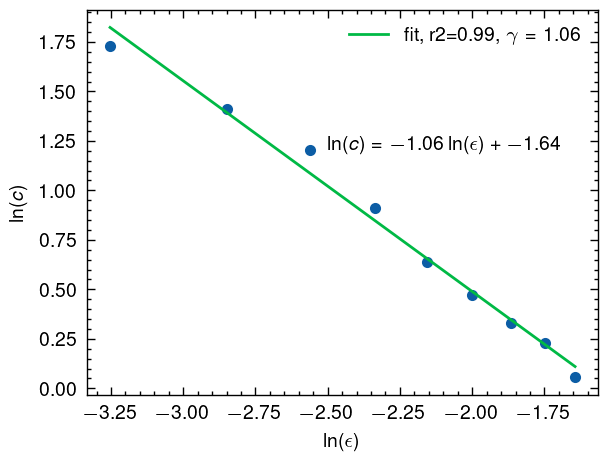

In [59]:
# For c, take log and curve fit
critical_idx = np.argwhere(T_series==T_c)[0][0]
c_around_Tc = C_series[critical_idx-10:critical_idx-1]
T_around_Tc = T_series[critical_idx-10:critical_idx-1]
eps = np.abs(1 - T_around_Tc/T_c)
eps_log = np.log(eps)
c_log = np.log(c_around_Tc)
slope, intercept, r_value, p_value, std_err = linregress(eps_log, c_log)
r2 = r_value**2
# plot data with fitted line and formula
plt.plot(eps_log, c_log, 'o')
plt.plot(eps_log, slope*eps_log+intercept, label=f'fit, r2={r2:.2f}, $\gamma={-slope:.2f}$')
# print the formula on the plot
plt.text(-2.5, 1.2, f'$\ln(c)={slope:.2f}\ln(\epsilon)+{intercept:.2f}$')
plt.xlabel('$\ln(\epsilon)$')
plt.ylabel('$\ln(c)$')
plt.legend()
plt.savefig(fig_dir+'c_around_Tc_left.png',dpi=300)
plt.show()

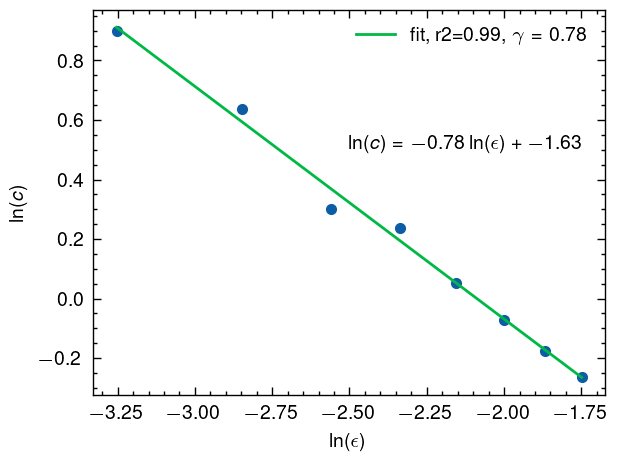

In [60]:
# For c, take log and curve fit
critical_idx = np.argwhere(T_series==T_c)[0][0]
c_around_Tc = C_series[critical_idx+2:critical_idx+10]
T_around_Tc = T_series[critical_idx+2:critical_idx+10]
eps = np.abs(1 - T_around_Tc/T_c)
eps_log = np.log(eps)
c_log = np.log(c_around_Tc)
slope, intercept, r_value, p_value, std_err = linregress(eps_log, c_log)
r2 = r_value**2
# plot data with fitted line and formula
plt.plot(eps_log, c_log, 'o')
plt.plot(eps_log, slope*eps_log+intercept, label=f'fit, r2={r2:.2f}, $\gamma={-slope:.2f}$')
# print the formula on the plot
plt.text(-2.5, 0.5, f'$\ln(c)={slope:.2f}\ln(\epsilon)+{intercept:.2f}$')
plt.xlabel('$\ln(\epsilon)$')
plt.ylabel('$\ln(c)$')
plt.legend()
plt.savefig(fig_dir+'c_around_Tc_right.png',dpi=300)
plt.show()

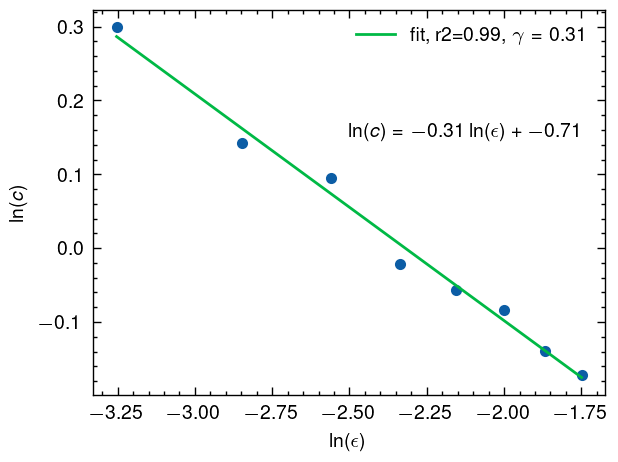

In [61]:
# For c, take log and curve fit
critical_idx = np.argwhere(T_series==T_c)[0][0]
xi_around_Tc = xi_series[critical_idx+2:critical_idx+10]
T_around_Tc = T_series[critical_idx+2:critical_idx+10]
eps = np.abs(1 - T_around_Tc/T_c)
eps_log = np.log(eps)
xi_log = np.log(xi_around_Tc)
slope, intercept, r_value, p_value, std_err = linregress(eps_log, xi_log)
r2 = r_value**2
# plot data with fitted line and formula
plt.plot(eps_log, xi_log, 'o')
plt.plot(eps_log, slope*eps_log+intercept, label=f'fit, r2={r2:.2f}, $\gamma={-slope:.2f}$')
# print the formula on the plot
plt.text(-2.5, 0.15, f'$\ln(c)={slope:.2f}\ln(\epsilon)+{intercept:.2f}$')
plt.xlabel('$\ln(\epsilon)$')
plt.ylabel('$\ln(c)$')
plt.legend()
plt.savefig(fig_dir+'xi_around_Tc_right.png',dpi=300)
plt.show()

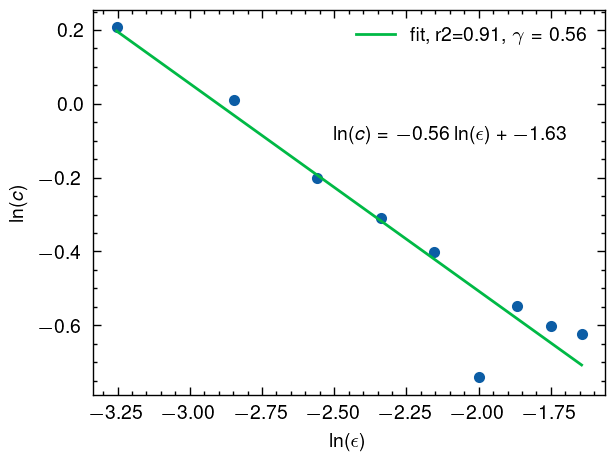

In [62]:
# For c, take log and curve fit
critical_idx = np.argwhere(T_series==T_c)[0][0]
xi_around_Tc = xi_series[critical_idx-10:critical_idx-1]
T_around_Tc = T_series[critical_idx-10:critical_idx-1]
eps = np.abs(1-T_around_Tc/T_c)
eps_log = np.log(eps)
xi_log = np.log(xi_around_Tc)
slope, intercept, r_value, p_value, std_err = linregress(eps_log, xi_log)
r2 = r_value**2
# plot data with fitted line and formula
plt.plot(eps_log, xi_log, 'o')
plt.plot(eps_log, slope*eps_log+intercept, label=f'fit, r2={r2:.2f}, $\gamma={-slope:.2f}$')
# print the formula on the plot
plt.text(-2.5, -0.1, f'$\ln(c)={slope:.2f}\ln(\epsilon)+{intercept:.2f}$')
plt.xlabel('$\ln(\epsilon)$')
plt.ylabel('$\ln(c)$')
plt.legend()
plt.savefig(fig_dir+'xi_around_Tc_left.png',dpi=300)
plt.show()